# Self-Driving Car Engineer Nanodegree


## Project: **Behavioral Cloning** 
***

I have decided to use a Jupyter notebook like the previous projects to do the initial work atleast.

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
import math
import os
import csv
import random
from scipy import signal
import tensorflow as tf
from glob import glob
import sklearn

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Lambda
from keras.layers import Cropping2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop

%matplotlib inline

## Read in Images

In [2]:
lines = []

with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#print(lines[0])
#print(lines[1])
#print(lines[2:4])

# This is required since the first line is comprised of headers.
lines = lines[1:]

train_samples, validation_samples = train_test_split(lines, test_size=0.2)

print(len(train_samples))
print(len(validation_samples))

6428
1608


In [3]:
images = []
measurements = []

for line in lines[1:]:
    #print(line)
    #print("")
    
    source_path = line[0]
    #print(source_path)
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    #print(current_path)
    image = cv2.imread(current_path)
    center_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(center_image)
    measurement = float(line[3])
    measurements.append(measurement)
    
    image_flipped = np.copy(np.fliplr(image))
    image_flipped_rgb = cv2.cvtColor(image_flipped, cv2.COLOR_BGR2RGB)
    images.append(image_flipped_rgb)
    measurement_flipped = -measurement
    measurements.append(measurement_flipped)

    source_path = line[1]
    #print(source_path)
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    #print(current_path)
    image = cv2.imread(current_path)
    left_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(left_image)
    measurement_l = measurement + 0.065
    measurements.append(measurement_l)
    

    source_path = line[2]
    #print(source_path)
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    #print(current_path)
    image = cv2.imread(current_path)
    right_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(right_image)
    measurement_r = measurement - 0.065
    measurements.append(measurement_r)



## Setup Training Data

In [4]:
X_train = np.array(images)
y_train = np.array(measurements)

## Nvidia Deep Learning Model

In [5]:
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Conv2D(24, 5, 5, subsample=(2,2), activation = 'relu'))
model.add(Conv2D(36, 5, 5, subsample=(2,2), activation = 'relu'))
model.add(Conv2D(48, 5, 5, subsample=(2,2), activation = 'relu'))
model.add(Conv2D(64, 3, 3, subsample=(1,1), activation = 'relu'))
model.add(Conv2D(64, 3, 3, subsample=(1,1), activation = 'relu'))

model.add(Flatten())
model.add(Dense(100))
#model.add(Dropout(0.4))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

## Compile The Model

In [6]:
#adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer='adam', loss='mse')

## Train The Model

In [7]:
epochs = 3

history_object = model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = epochs)

Train on 25712 samples, validate on 6428 samples
Epoch 1/3
25712/25712 [==============================] - 59s - loss: 0.0108 - val_loss: 0.0103
Epoch 2/3
25712/25712 [==============================] - 58s - loss: 0.0096 - val_loss: 0.0102
Epoch 3/3
25712/25712 [==============================] - 58s - loss: 0.0091 - val_loss: 0.0103


## Save the Model

In [8]:
model.save('model.h5')

dict_keys(['val_loss', 'loss'])


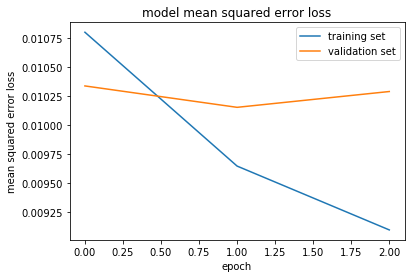

In [9]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()